# Example Optimization on 8x8 Split-Ring Structure

In [1]:
import os, sys
import torch
import mlflow
import numpy as np
import matplotlib.pyplot as plt

from DiffSimPyPipeline import CalculationPipeline as pipeline
import NetworkFunctions
from OptimizationFunctions import create_folders

from cosimpy import S_Matrix, EM_Field

## General Initialization

In [2]:
path = "./data/8x8"
freq = 123.5 #MHz
numPorts = 65

s_matrix = S_Matrix.importTouchstone(os.path.join(path, f"s_param.s{numPorts}p"))

In [3]:
s_matrix = S_Matrix.importTouchstone(os.path.join(path, f"s_param.s{numPorts}p"))
em_field = EM_Field.importFields_cst(os.path.join(path, "Field"), 
                                        freqs=[freq], 
                                        nPorts=numPorts, 
                                        Pinc_ref=1, 
                                        b_multCoeff=1,
                                        pkORrms='rms',
                                        fileType = 'ascii', 
                                        col_ascii_order = 1)

s_matrix_unconnected = torch.from_numpy(s_matrix.S).to(torch.cdouble)
b_field_import = torch.tensor(em_field.b_field, dtype=torch.cdouble)

Importing 123.5 MHz fields

	Importing port65 fields



In [4]:
# For Optimization: Only interested in field in centre of each cell at 123.5MHz
b_field_import_for_optimization = b_field_import#torch.reshape(b_field_import[:,:,:,:], (1, 65, 3, 449, 449))
freq_id = np.where(s_matrix.frequencies == freq*10**6)[0][0]

In [6]:
num_epochs = 2000
learning_rate = 1e-13
experiment_name = "GD_8x8_DEMO"

## Initialization of DiffSimPy Pipeline

In [7]:
n0=numPorts
n1=1
nf=1
batch_size=1

S_C_const = torch.zeros((batch_size, nf, n0+n1, n0+n1), dtype=torch.cdouble)
S_C_const[:, :, -1, 0] = 1
S_C_const[:, :, 0, -1] = 1
# Transmission from excitation port to all other ports

In [8]:
id_x = [x+n1 for x in range(numPorts-n1)]
indices = torch.tensor([id_x, id_x]) #define indices for S_C

In [9]:
calc_pipe = pipeline(S_0 = s_matrix_unconnected[freq_id], # as we are only interested in 123.5MHz, we can neglect other frequencies
                     S_C_const = S_C_const,
                     b_field = b_field_import_for_optimization,
                     e_field = None)

In [10]:
omega = 2*torch.pi*freq*10**6

In [11]:
slice_of_interest_obj = (slice(None), 0, 0, -1, slice(None))

# Desired B Field generation

In [12]:
def custom_preprocessing(Rvalue, Cvalue, omega):
    z = NetworkFunctions.calc_RC_series_impedance(Rvalue, Cvalue, omega)
    s = NetworkFunctions.z_to_s(z, 50)
    s = s.unsqueeze(1) #add dimension for nf
    return s

In [13]:
def inverse_minmax_scaler(max_value: float, 
                          min_value: float,
                          tensor: torch.Tensor) -> torch.Tensor:
    return tensor*(max_value-min_value) + min_value

In [14]:
Y_0 = S_Matrix.getYMatrix(s_matrix)
y = torch.from_numpy(Y_0[freq_id, 1:, 1:]) #drops excitation coil
c_init = NetworkFunctions.extract_initial_params(omega, y)
#NetworkFunctions.export_params_to_txt(c_init*1e12, "C", f"./output/{experiment_name}resonance_config_8x8.txt")

In [15]:
desired_h_boundary_c = torch.vstack((torch.ones_like(c_init)*1e-12, torch.ones_like(c_init)*60e-12, c_init))

In [16]:
boundary = torch.abs(calc_pipe(custom_preprocessing(torch.ones_like(desired_h_boundary_c), desired_h_boundary_c, omega), indices)[0][slice_of_interest_obj])

In [ ]:
max_h = torch.max(boundary)
min_h = torch.min(boundary)

print(f"Max H: {max_h}, Min H: {min_h}")

Max H: 0.026988247749958758, Min H: 0.008662274104031548


In [18]:
from letters_to_array import generate_letter_matrix
import string

letters = list(string.ascii_uppercase) + list(string.digits)
letter_list = []
for letter in letters:
    letter_list.append(generate_letter_matrix(letter).flatten())

letters_and_digits = torch.tensor(np.array(letter_list))

In [19]:
from scipy.linalg import hadamard
n_col_points = 8
hadamard_pattern = torch.tensor((hadamard(n_col_points) + 1) / 2).flatten()
gradient_array = np.linspace(0, 1, n_col_points)
homogenization_pattern = torch.ones((n_col_points, n_col_points*n_col_points))*gradient_array[:, np.newaxis]

In [20]:
desired_h = inverse_minmax_scaler(max_value=max_h, min_value=min_h, tensor=torch.vstack((letters_and_digits, hadamard_pattern, homogenization_pattern)))

# Optimization

In [21]:
eval_loss_obj = torch.nn.MSELoss()
eval_loss_obj_no_reduction = torch.nn.MSELoss(reduction='none')

In [22]:
mlflow.set_tracking_uri('./mlruns')
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='/workspace/diffsimpy/example/mlruns/118678836729410610', creation_time=1733834924505, experiment_id='118678836729410610', last_update_time=1733834924505, lifecycle_stage='active', name='GD_8x8_DEMO', tags={}>

In [23]:
create_folders(f"./output/{experiment_name}")
# parametric_sweep initial params

initial_params = c_init.unsqueeze(0).repeat(len(desired_h), 1).detach().requires_grad_(True)
optimizer = torch.optim.Adam([initial_params], lr=learning_rate)
mlflow.start_run()

# Optimization procedure
prev_best_eval_loss = 1
best_params = initial_params
best_params_epoch = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Clear gradients

    s_opt = custom_preprocessing(torch.ones_like(initial_params), initial_params, omega)
    output = calc_pipe(s_opt, indices)  # Forward pass
    opt_field = torch.abs(output[0][slice_of_interest_obj])
    loss = eval_loss_obj(opt_field, desired_h)  # Compute loss
    loss.backward()  # Backward pass to compute gradients
    optimizer.step()  # Update parameters
    
    eval_loss = loss.item()
    if eval_loss<=prev_best_eval_loss:
        if epoch - best_params_epoch > 3:
            print(f"best_eval_loss: {eval_loss} @ epoch {epoch}")
        best_params = initial_params
        best_params_epoch = epoch
        best_params_output = opt_field
        prev_best_eval_loss = eval_loss
        
    if epoch == 0:
        opt_field_init = opt_field    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    mlflow.log_metric("MSE", loss.item(), step=epoch)

mlflow.log_metric("best_params_epoch", best_params_epoch)
mlflow.log_metric("best_eval_loss", prev_best_eval_loss)
torch.save(best_params, f"./output/{experiment_name}/best_params.pt")
torch.save(best_params_output, f"./output/{experiment_name}/best_params_output.pt")
torch.save(desired_h, f"./output/{experiment_name}/desired_field.pt")
#mlflow.log_artifact("/workspace")
#mlflow.log_artifact("/packages")
mlflow.end_run()

Directory "./output/GD_8x8_DEMO" already exists
Epoch 0, Loss: 0.00012421001013366737
Epoch 100, Loss: 3.2118101319340646e-06
Epoch 200, Loss: 1.5252472891935245e-06
Epoch 300, Loss: 1.0019534242262094e-06
Epoch 400, Loss: 7.510412122229877e-07
Epoch 500, Loss: 6.061970322060518e-07
Epoch 600, Loss: 5.11988813978509e-07
Epoch 700, Loss: 4.465557636305093e-07
Epoch 800, Loss: 3.9787993435868313e-07
Epoch 900, Loss: 3.6122080109055454e-07
Epoch 1000, Loss: 3.326361547614374e-07
Epoch 1100, Loss: 3.103066538523986e-07
Epoch 1200, Loss: 2.9218748809751945e-07
best_eval_loss: 2.8719397809998805e-07 @ epoch 1236
Epoch 1300, Loss: 2.772586852332171e-07
best_eval_loss: 2.6916363667921657e-07 @ epoch 1367
best_eval_loss: 2.671918385587429e-07 @ epoch 1385
Epoch 1400, Loss: 2.6509340125289746e-07
best_eval_loss: 2.6018847905475945e-07 @ epoch 1445
best_eval_loss: 2.556862899625969e-07 @ epoch 1489
Epoch 1500, Loss: 2.5434758570299036e-07
best_eval_loss: 2.4928453551138995e-07 @ epoch 1557
best_e

In [24]:
print(f"final error {eval_loss}, best error {prev_best_eval_loss}, best epoch {best_params_epoch}")

final error 2.2000120881238565e-07, best error 2.2000120881238565e-07, best epoch 1999


In [25]:
def extract_indices_of_quartiles(metric_list: np.ndarray) -> dict:
    return {
        "Min": np.argsort(metric_list)[0],
        "Q1": np.argsort(metric_list)[len(metric_list)//4],
        "Q2": np.argsort(metric_list)[len(metric_list)//2],
        "Q3": np.argsort(metric_list)[int(len(metric_list)*(3/4))],
        "Max": np.argsort(metric_list)[-1]
     }


In [26]:
eval_mse = torch.nn.MSELoss(reduction='none')
mse_list = torch.mean(eval_mse(best_params_output, desired_h), axis=1)
indices_of_quartiles = extract_indices_of_quartiles(mse_list.tolist())

In [27]:
plt.rcParams.update({
    "figure.figsize": (3.5, 3.5),
    "font.size": 8 
})

In [28]:
from matplotlib.gridspec import GridSpec
def plt_distribution(realized, desired, vmin, vmax, mse_list, indices_of_quartiles, experiment_name):
    fig = plt.figure(figsize=(3.5, 7.5))
    gs = GridSpec(6, 3, width_ratios=[1, 1, 0.1], figure=fig)

    #fig.suptitle(f"Distribution Plots")
    plt.align_labels = True

    for count, key in enumerate(indices_of_quartiles.keys()):
        for col_ind in range(0, 2):
            field = [realized, desired]
            ax = fig.add_subplot(gs[count, col_ind])
            #ax = fig.add_subplot(gs[count, col_ind])
            if col_ind == 0 and count == 0:
                ax.set_title(r"$|\hat{H}_z|  \text{ } / \text{ }  |H_z|_{ref}$")
            elif col_ind == 1 and count == 0:
                ax.set_title(r"$|H_z|  \text{ } / \text{ }  |H_z|_{ref}$")
            ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
            img = ax.imshow(field[col_ind][indices_of_quartiles[key]].reshape((8,8)), vmin=vmin, vmax=vmax, cmap='gray') 
            if col_ind == 0:
                ax.set_ylabel(key)
            ax.set_xticks(np.arange(0, 8, 2))
            ax.set_yticks(np.arange(0, 8, 2))

    cbar_ax = fig.add_subplot(gs[:-1, 2])
    fig.colorbar(img, cax=cbar_ax)
    hist_ax = fig.add_subplot(gs[-1, :])

    hist_ax.hist(mse_list.detach().numpy(), bins=50, color='black')
    hist_ax.set_ylabel("Count")
    hist_ax.set_title(f"MSE Distribution")

    #axs[row_ind, col_ind].legend(handles, labels, loc='best')

    fig.align_ylabels()
    plt.tight_layout()
    plt.savefig(f"./output/{experiment_name}/mse_distribution_plot.pdf")
    plt.savefig(f"./output/{experiment_name}/mse_distribution_plot.png")

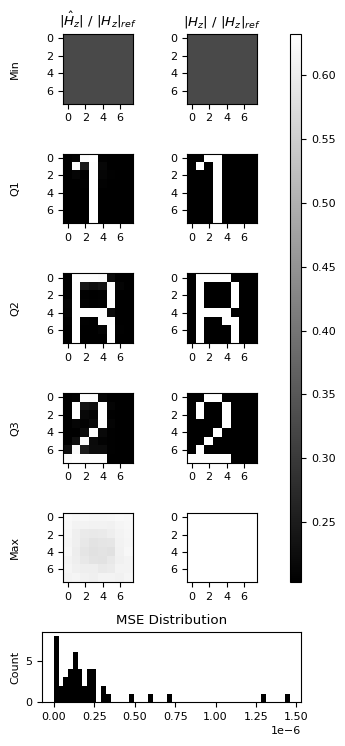

In [29]:
ref_one_cell = 0.0427 #A/m from cell #28
plt_distribution(best_params_output.detach().numpy()/ref_one_cell, desired_h.detach().numpy()/ref_one_cell, min_h/ref_one_cell, max_h/ref_one_cell, mse_list, indices_of_quartiles, experiment_name)